 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8887/notebooks/keras/Mikes_inout.ipynb#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/Mikes_inout.ipynb#Quick-test-network" data-toc-modified-id="Quick-test-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quick test network</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/Mikes_inout.ipynb#Check-model-predictions" data-toc-modified-id="Check-model-predictions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check model predictions</a></span><ul class="toc-item"><li><span><a href="http://localhost:8887/notebooks/keras/Mikes_inout.ipynb#Visualize-random-predictions" data-toc-modified-id="Visualize-random-predictions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Visualize random predictions</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/Mikes_inout.ipynb#X-Y-slices-of-precipitation-and-OLR" data-toc-modified-id="X-Y-slices-of-precipitation-and-OLR-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>X-Y slices of precipitation and OLR</a></span></li></ul></li></ul></div>

# Predictions with new input/output variables

Some visualization again for the predictions with 
- Inputs: [TAP, QAP, dTdt_adiabatic, dQdt_adiabatic, SHFLX, LHFLX] —> 86 vars
- Outputs: [SPDT, SPDQ, QRL, QRS, PRECT, FLUT] —> 86 vars

## Setup

In [217]:
# Imports 
from importlib import reload
import utils; reload(utils); from utils import *
import data_generator; reload(data_generator); from data_generator import *
import models; reload(models); from models import *

In [104]:
# Limit Tensorflow GPU memory usage. 
# Note that it's not possible to change the allocation or release memory again.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True   # Allocates as much memory as needed.
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [133]:
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in metrics])
get_custom_objects().update(metrics_dict)

In [3]:
# Plotting setup
%matplotlib inline
np.random.seed(42)
sns.set_style('dark')
sns.set_palette('deep')
sns.set_context('talk')
plt.rcParams["figure.figsize"] = (10,7)

In [4]:
# Define data paths
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/preprocessed_data/Mikes_inout/' # Full dataset
%ls $data_dir

SPCAM_mean_detailed.nc              SPCAM_outputs_valid_by_lon_flat.nc
SPCAM_outputs_detailed.nc           SPCAM_std_detailed.nc
SPCAM_outputs_train_by_lon_flat.nc


In [14]:
# Define a dictionary containing the feature and target variables
# and the number of dimensions
feature_vars = OrderedDict({
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
})
target_vars = OrderedDict({
    'SPDT': 2,            # SP temperature tendency [z, sample]
    'SPDQ': 2,            # SP humidity tendency [z, sample]
    'QRL': 2,
    'QRS': 2,
    'PRECT': 1,
    'FLUT': 1,
})

## Check model predictions

In [218]:
# Load the dataset
train_set_lon = DataSet(data_dir, 'SPCAM_outputs_train_by_lon_flat.nc', 'SPCAM_mean_detailed.nc',
                        'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                        target_names=target_vars.keys())
valid_set_lon = DataSet(data_dir, 'SPCAM_outputs_valid_by_lon_flat.nc', 'SPCAM_mean_detailed.nc',
                        'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                        target_names=target_vars.keys())

In [219]:
model2 = keras.models.load_model('./models/fc_1024_1024_512_512_by_lon_inout_Mike_new_norm.h5')

In [273]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              89088     
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 86)                44118     
Total params: 1,970,262
Trainable params: 1,970,262
Non-trainable params: 0
_________________________________________________________________


In [220]:
preds2 = model2.predict(valid_set_lon.features, batch_size=1024)

### Visualize random predictions

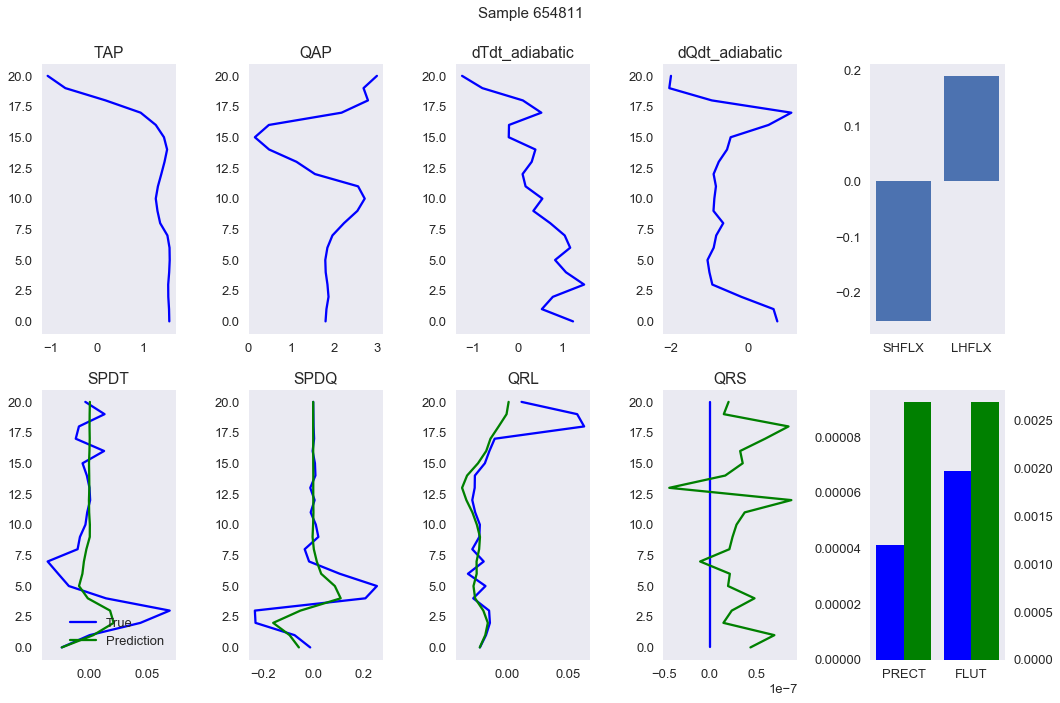

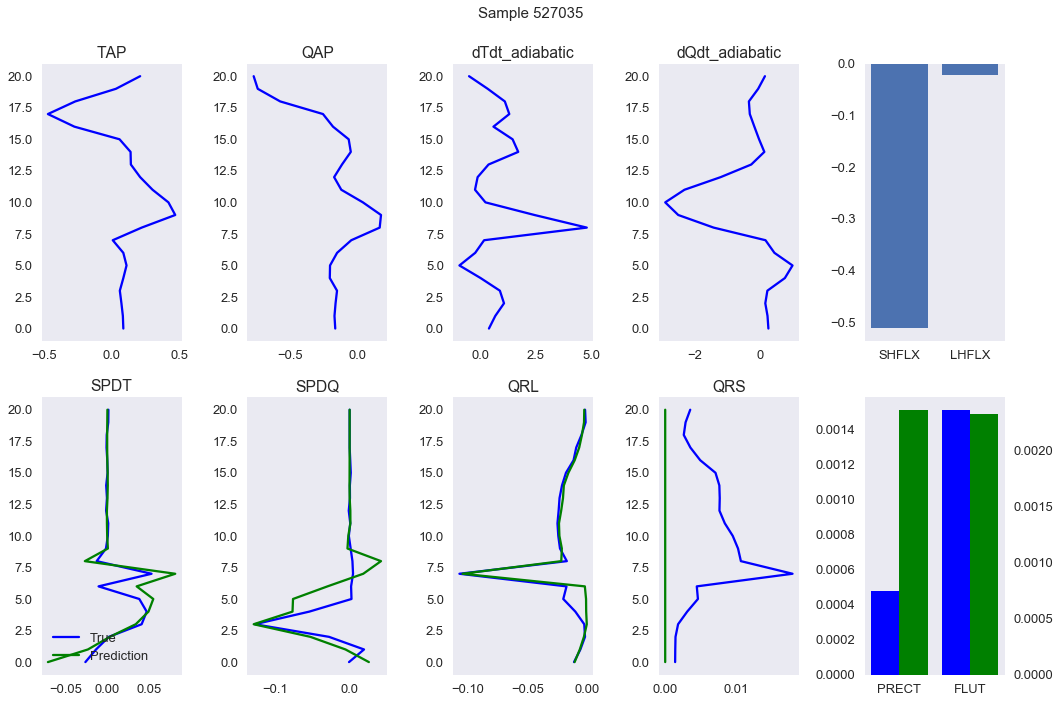

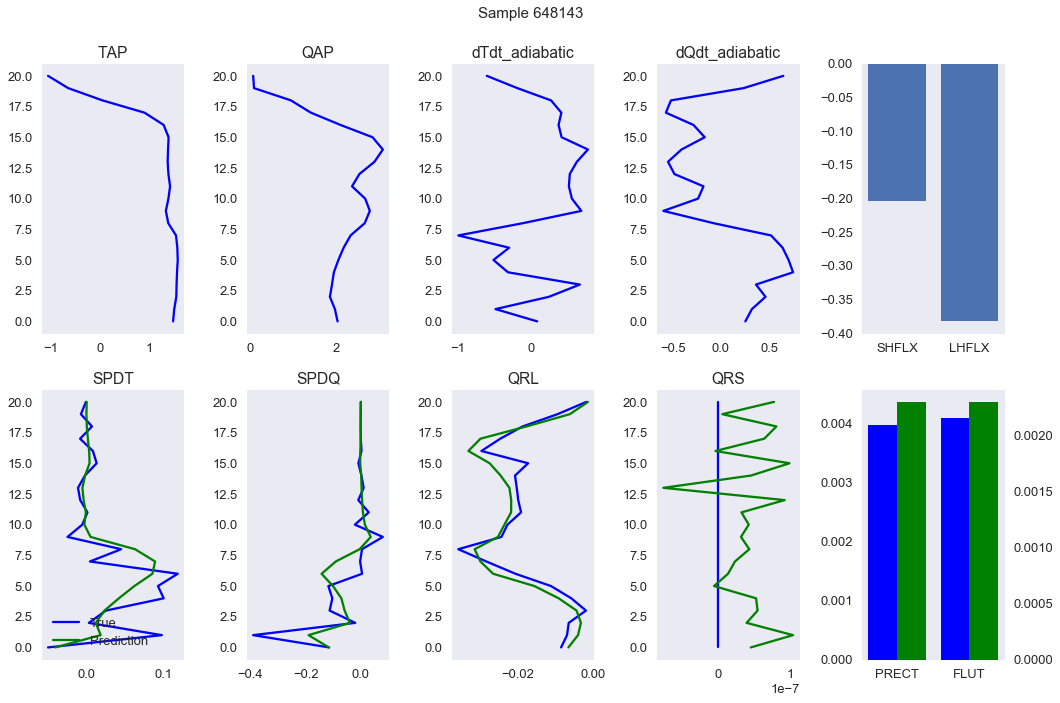

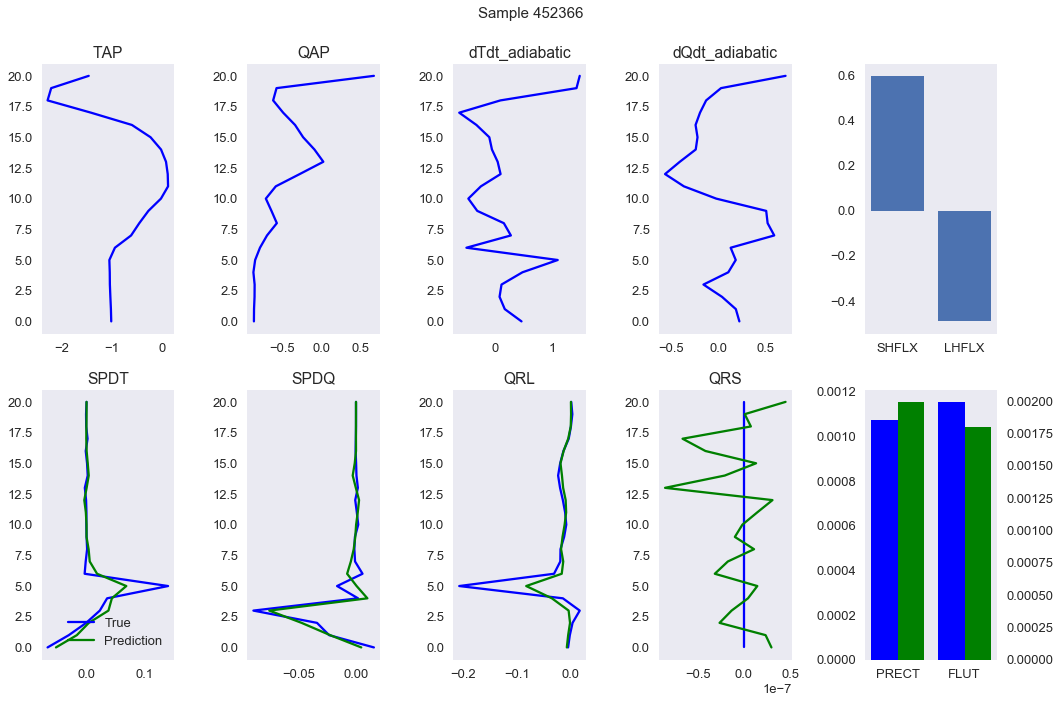

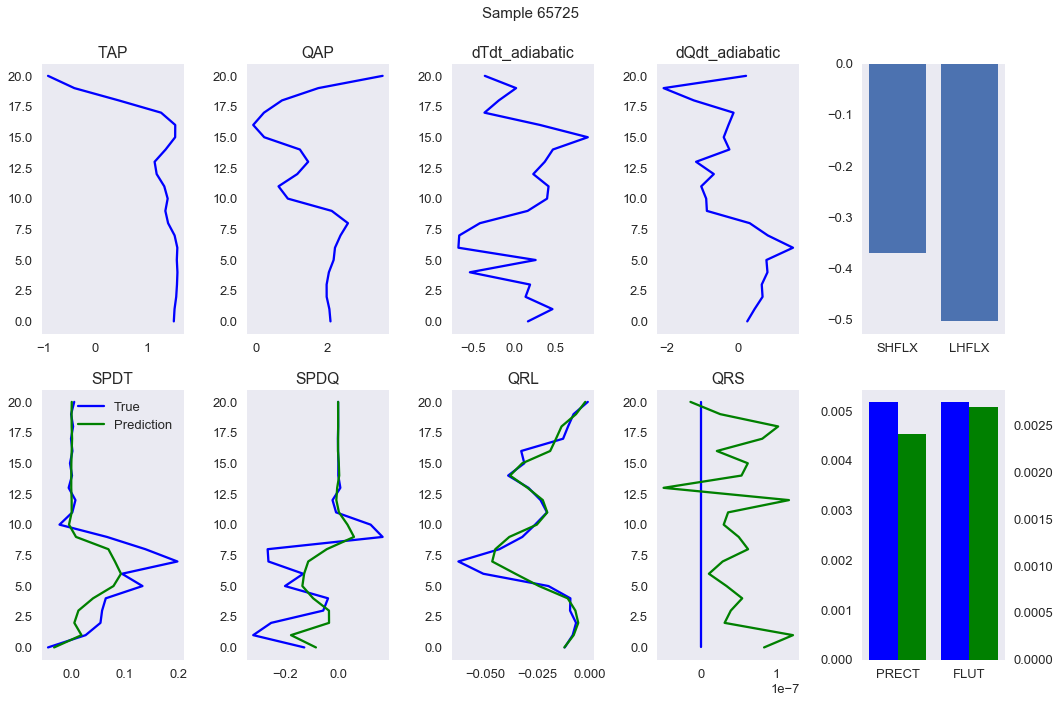

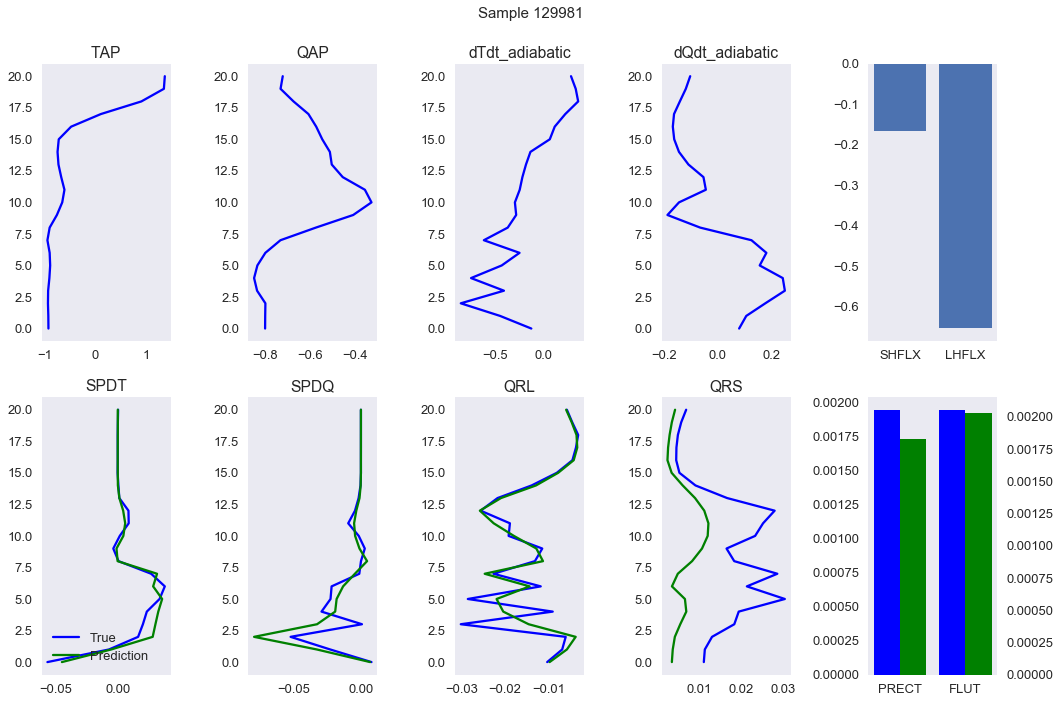

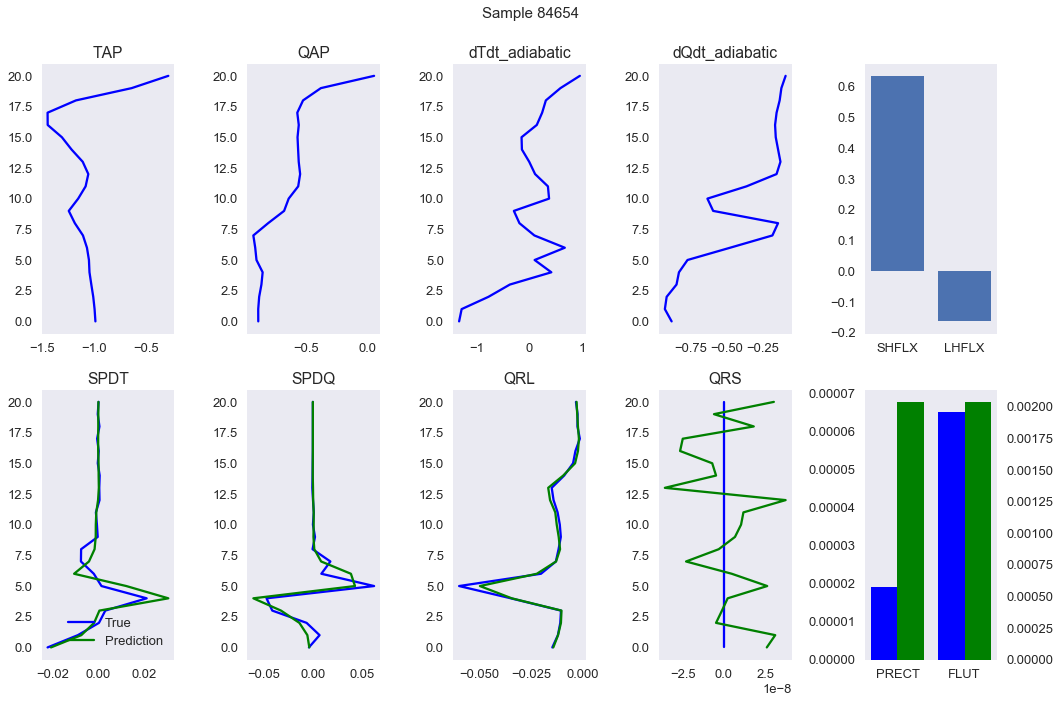

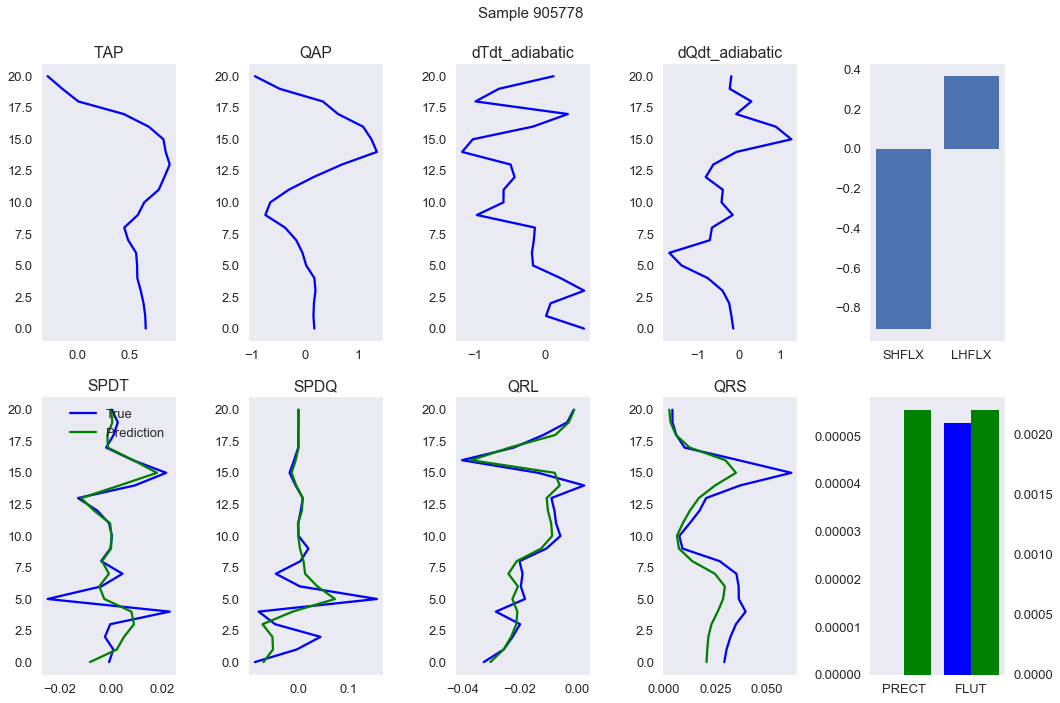

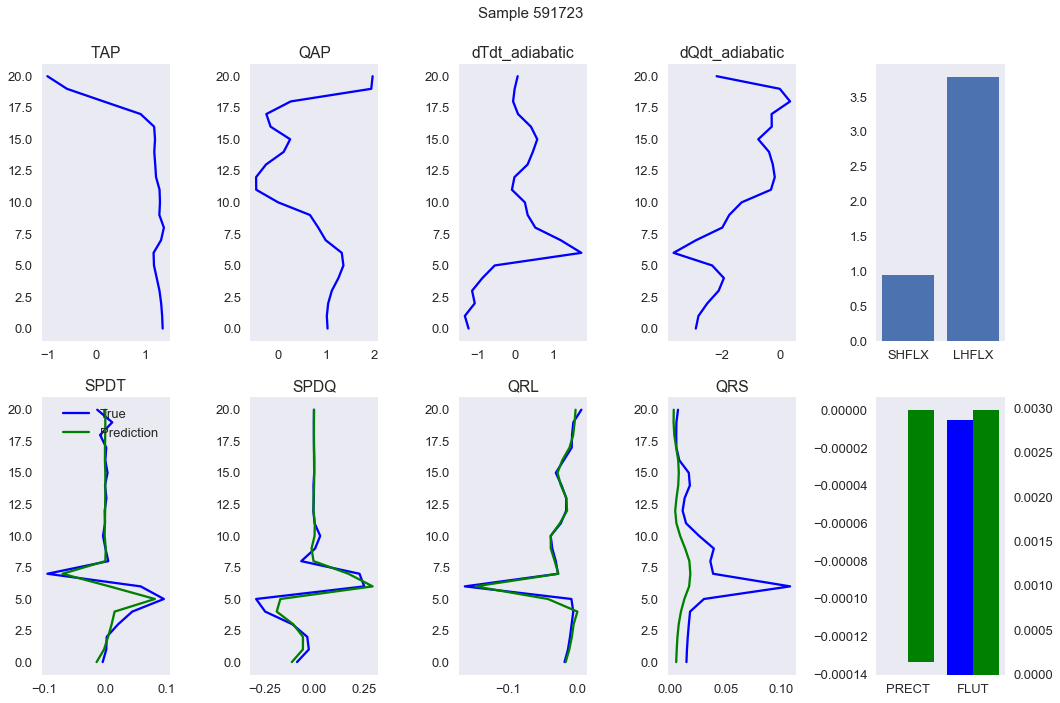

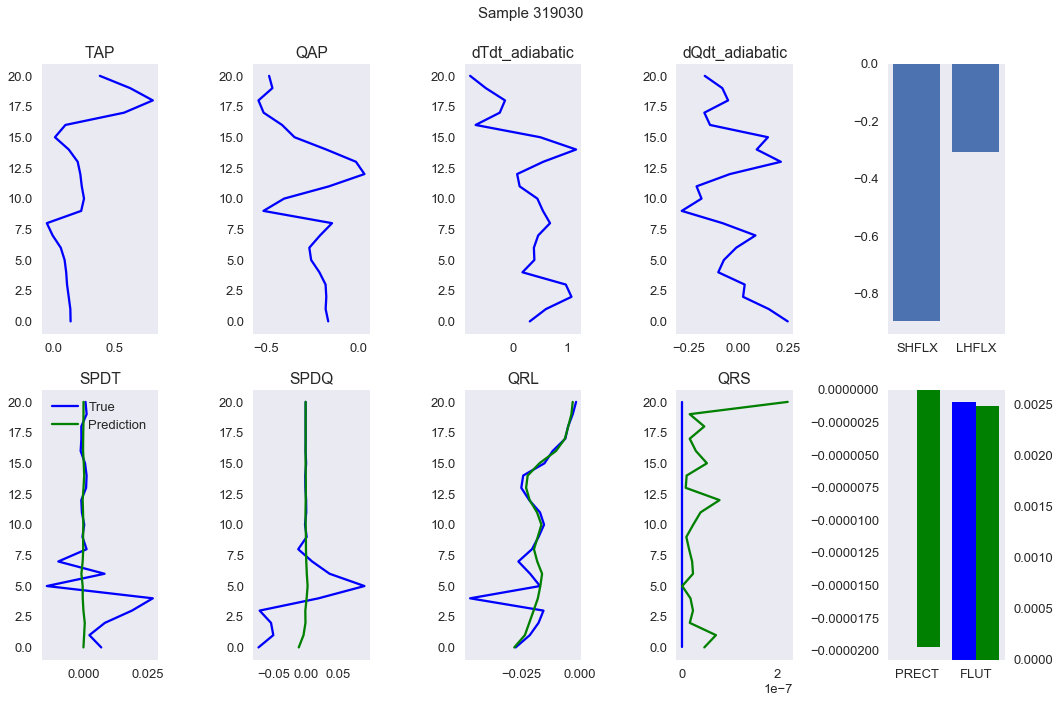

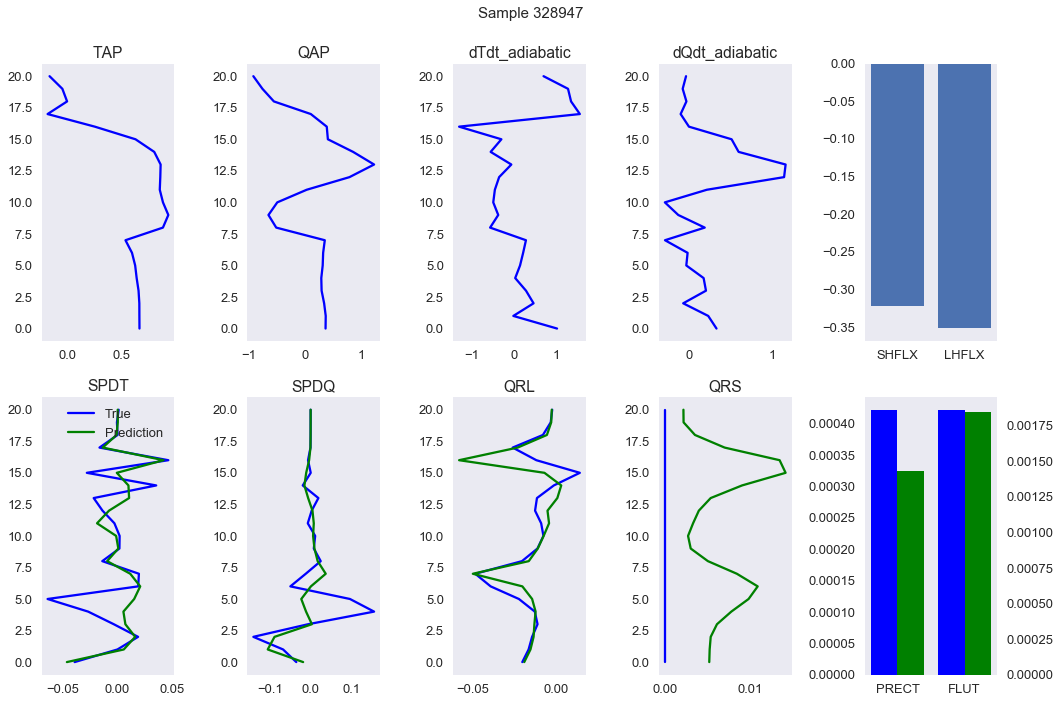

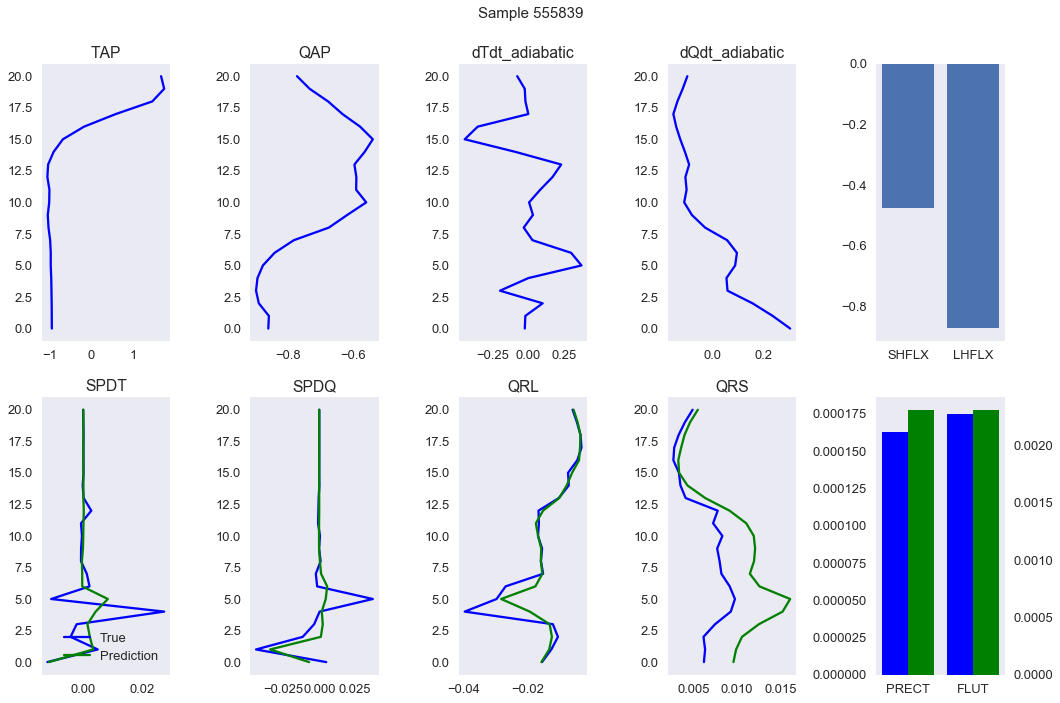

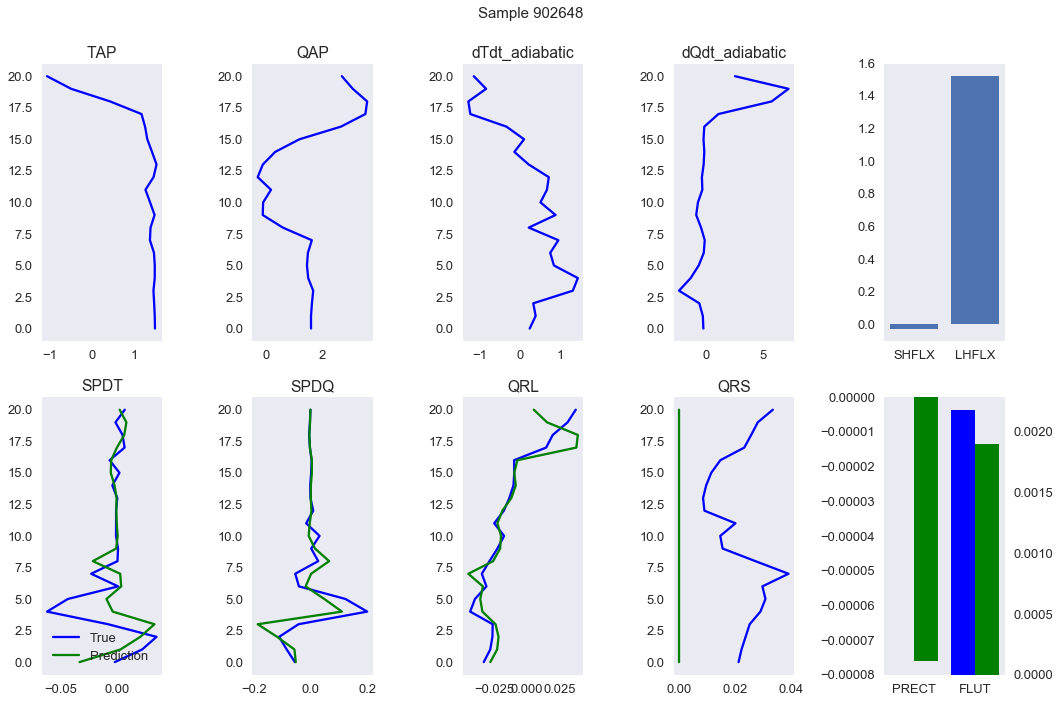

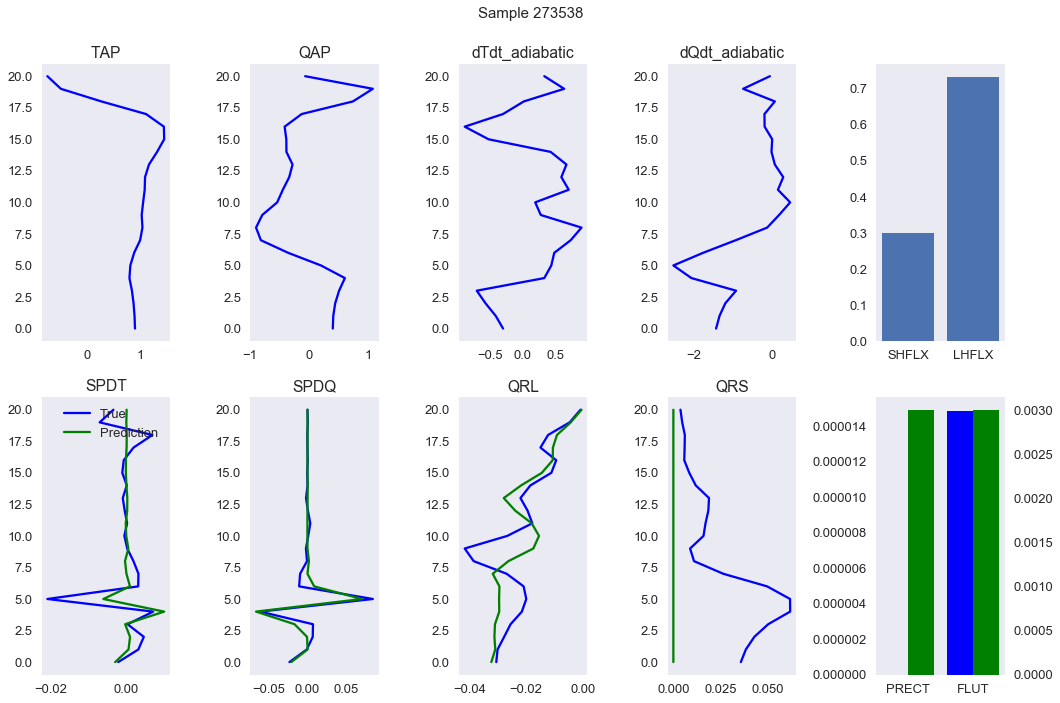

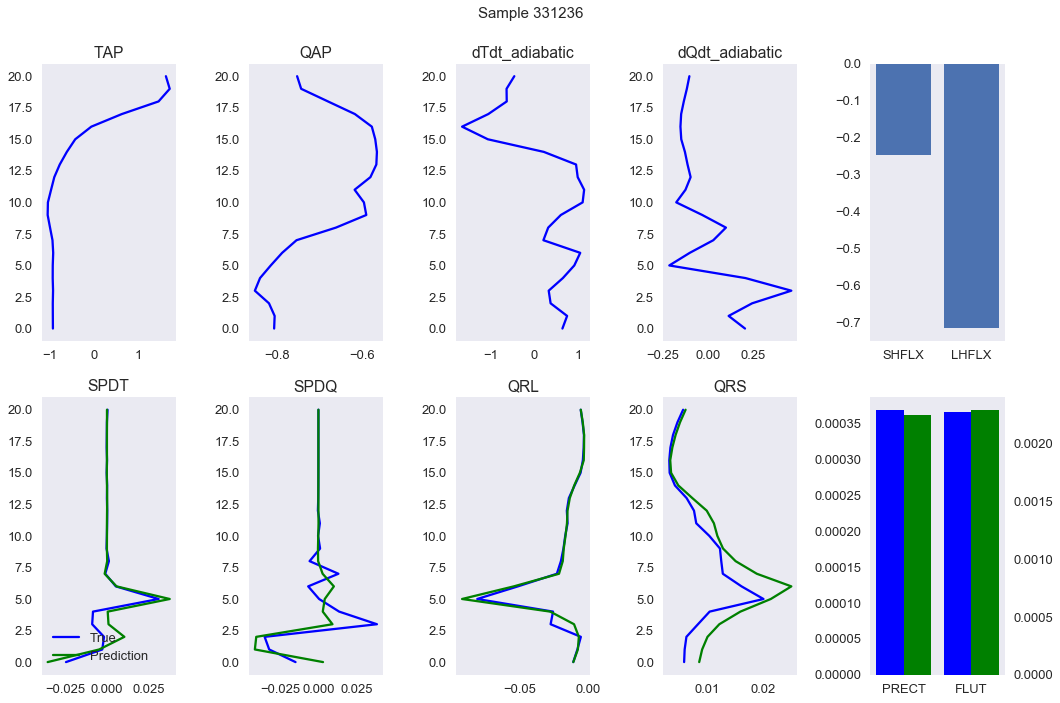

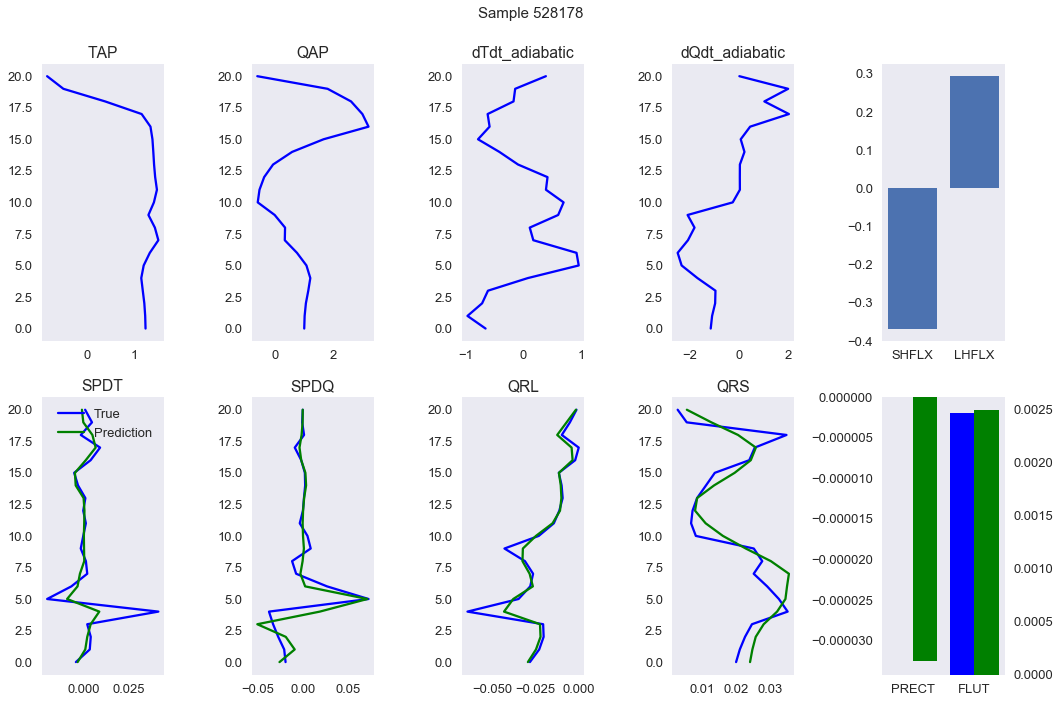

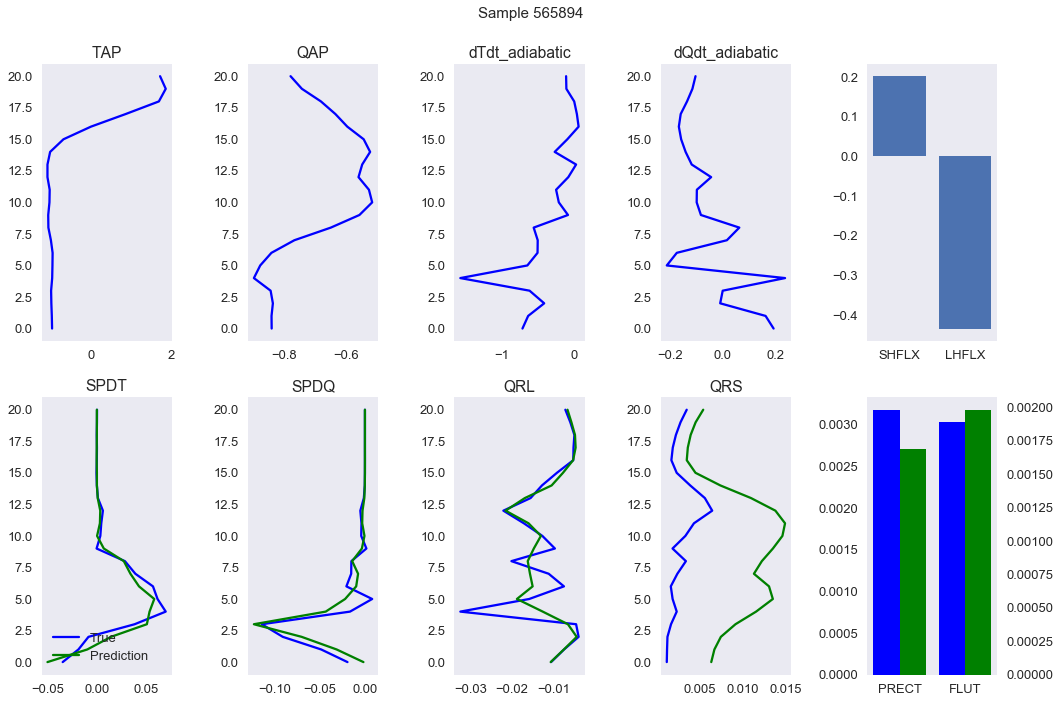

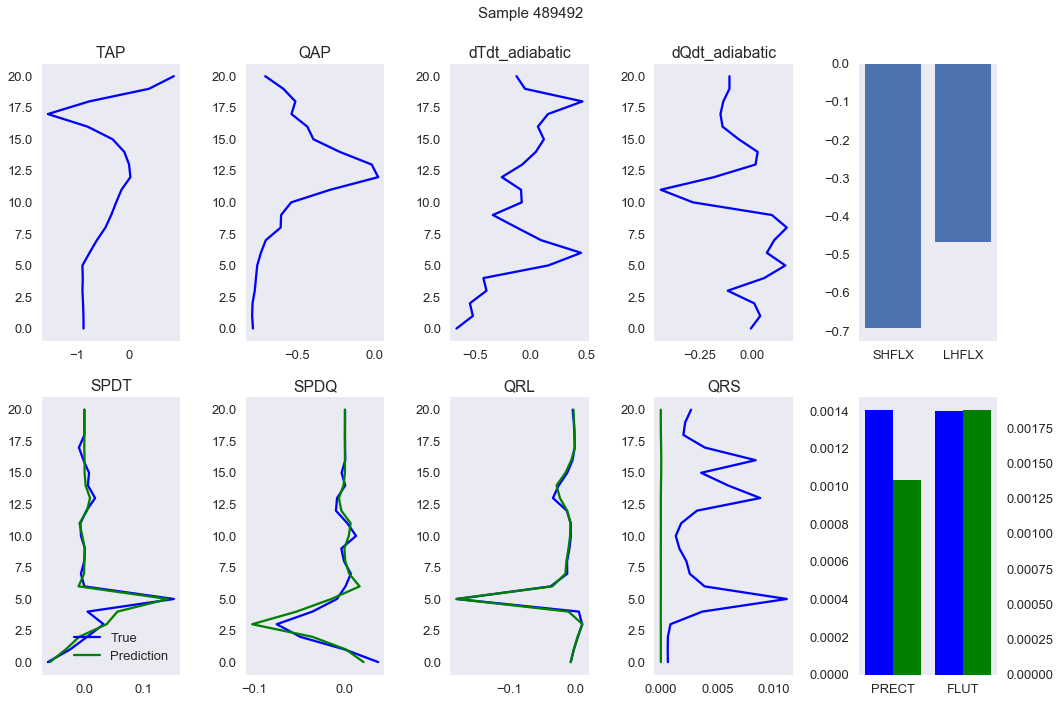

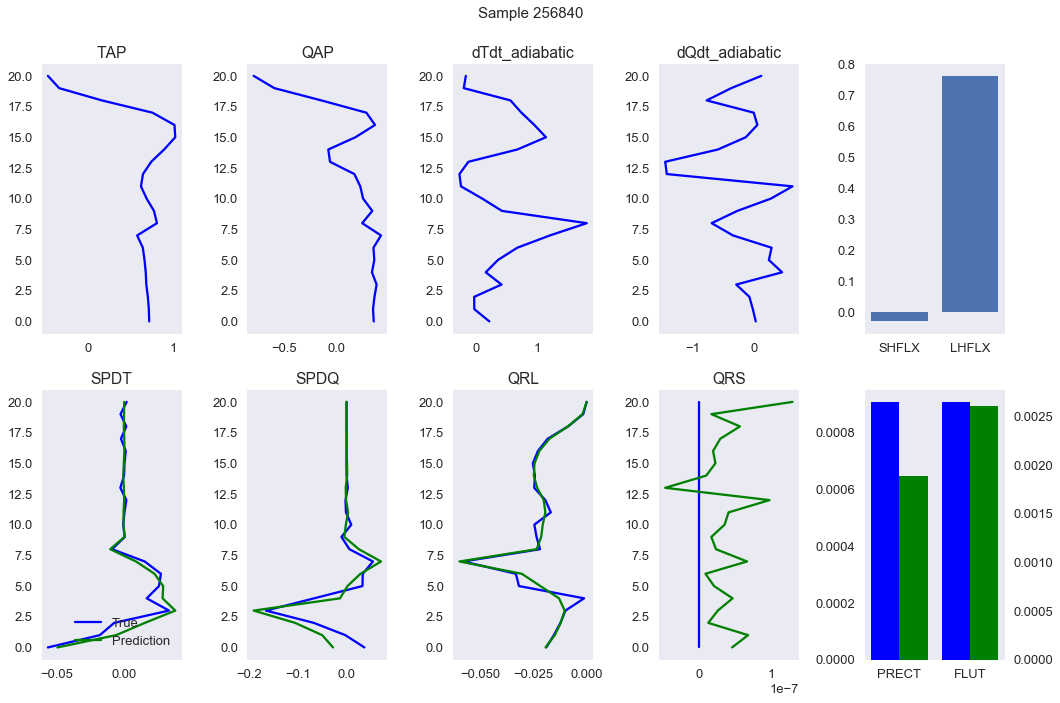

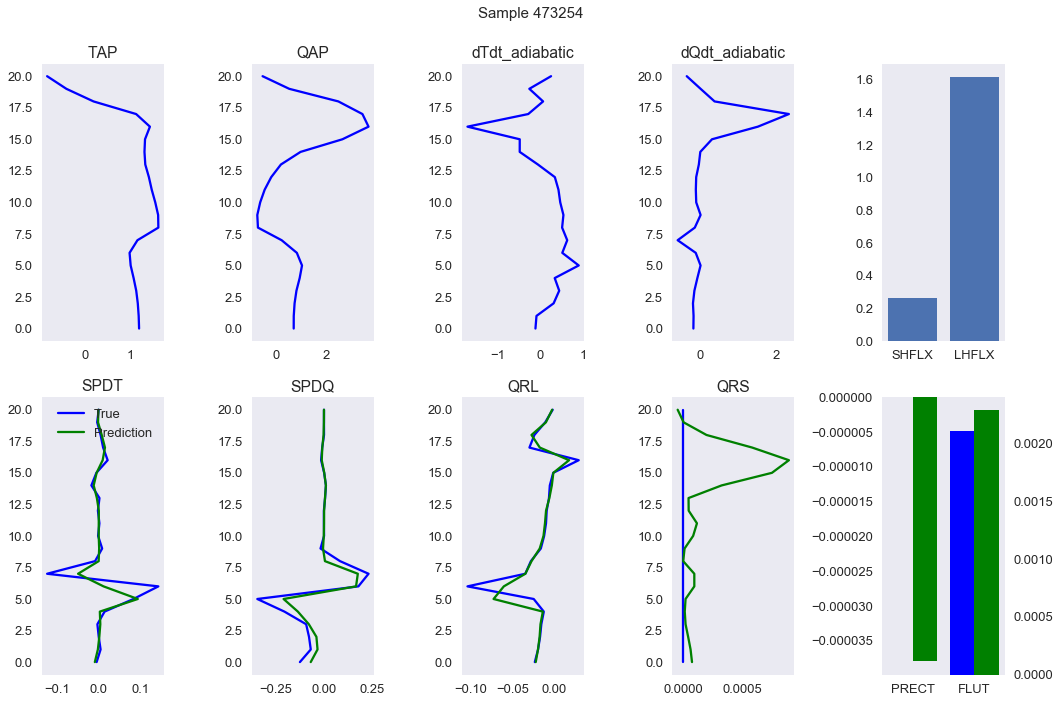

In [228]:
for i in list(np.random.randint(0, valid_set_lon.features.shape[0], 20)):
    vis_features_targets_from_pred2(valid_set_lon.features, 
                                       valid_set_lon.targets, preds2,
                                       i, list(valid_set_lon.feature_names), 
                                       list(valid_set_lon.target_names))

Some things I noticed:
- Precipitation can go negative. It is also very non-gaussian. A good transformation would be beneficial probably. Or a different final activation function (why not relu?)
- The OLR (=FLUT) is actually pretty constant, so here a mean-std normalization would potentially be useful
- QRS is terrible, but the net also does not get any information on incoming solar radiation... Would QRS at the top be a good parameter?

### X-Y slices of precipitation and OLR

In [231]:
targets_re = np.reshape(valid_set_lon.targets, (12, 47, 64, 26, 86))
preds_re = np.reshape(preds2, (12, 47, 64, 26, 86))

In [270]:
def plot_xy(targets_re, preds_re, idate, itime, ifeat):
    feat_name = list(valid_set_lon.target_names)[ifeat]
    fig, axes = plt.subplots(1, 3)
    mn = np.minimum(targets_re[idate, itime, :, :, ifeat], 
                    preds_re[idate, itime, :, :, ifeat]).min()
    mx = np.maximum(targets_re[idate, itime, :, :, ifeat], 
                    preds_re[idate, itime, :, :, ifeat]).max()
    I = axes[0].imshow(targets_re[idate, itime, :, :, ifeat], cmap='inferno_r', vmin=mn, vmax=mx)
    axes[0].set_title('True ' + feat_name)
    fig.colorbar(I, ax=axes[0], shrink=0.4)
    I = axes[1].imshow(preds_re[idate, itime, :, :, ifeat], cmap='inferno_r', vmin=mn, vmax=mx)
    axes[1].set_title('Predicted ' + feat_name)
    fig.colorbar(I, ax=axes[1], shrink=0.4)
    error = preds_re[idate, itime, :, :, ifeat] - targets_re[idate, itime, :, :, ifeat]
    mx_err = np.max(np.abs(error))
    I = axes[2].imshow(error, cmap='bwr', vmin=-mx_err, vmax=mx_err)
    axes[2].set_title('Error ' + feat_name)
    fig.colorbar(I, ax=axes[2], shrink=0.4)
    plt.tight_layout(); plt.show()

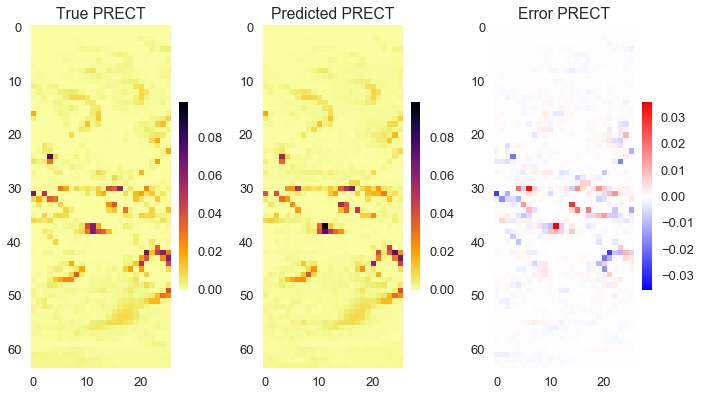

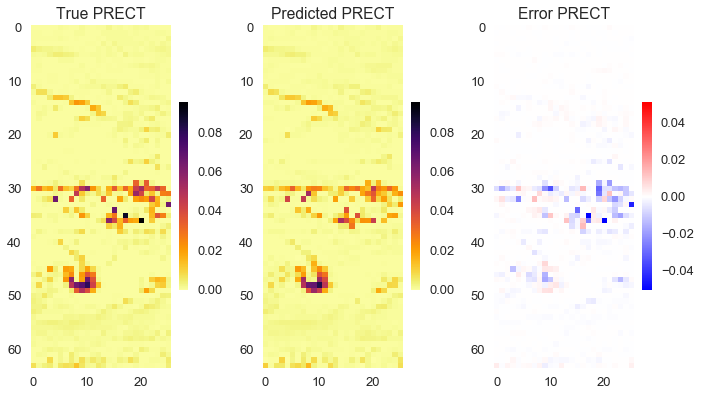

In [271]:
# Just some random plots
plot_xy(targets_re, preds_re, 0, 12, -2)
plot_xy(targets_re, preds_re, 10, 40, -2)

So this actually looks pretty good. What about OLR.

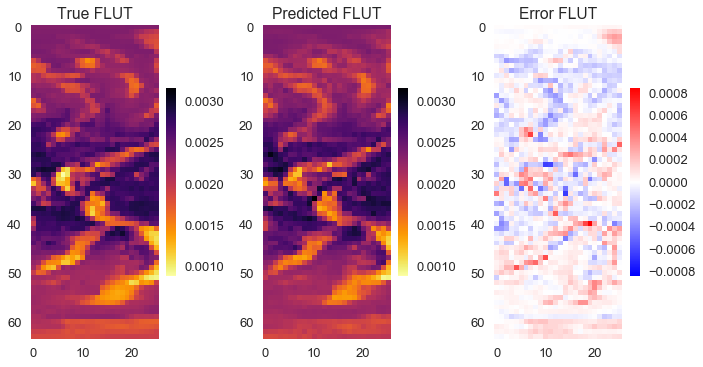

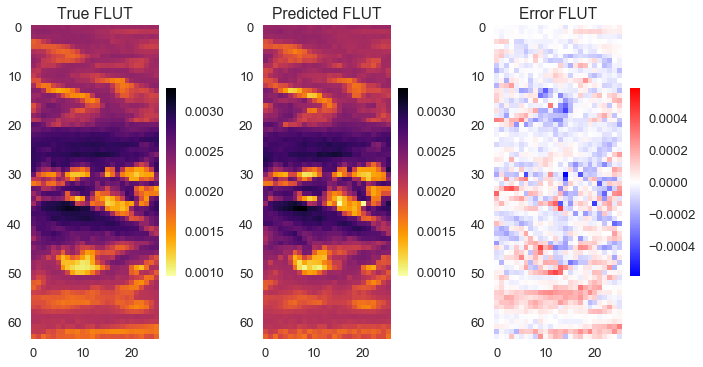

In [272]:
plot_xy(targets_re, preds_re, 0, 12, -1)
plot_xy(targets_re, preds_re, 10, 40, -1)

Also pretty impressive.